#Data Dictionnary

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import libraries


In [31]:
# Importing the libraries 
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing,metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz,DecisionTreeRegressor

# import graph objects as "go"
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.express as px
import plotly.figure_factory as ff


%matplotlib inline

# Data Exploration

In [32]:
data=pd.read_csv('/content/drive/My Drive/AE_PJ/wiki.csv')
data.head()

,Unnamed: 0,X,Vandal,Minor,Loggedin,Added,Removed
0,1,1,0,1,1,represent psycholinguisticspsycholinguistics...,
1,2,2,0,1,1,website external links,talklanguagetalk
2,3,3,0,0,1,,regarded as technologytechnologies human first
3,4,4,0,1,0,afghanistan used iran mostly that farsiis is ...,represent psycholinguisticspsycholinguistics...
4,5,5,0,1,1,represent psycholinguisticspsycholinguistics...,afghanistan used iran mostly that farsiis is ...


#Problem 1 - Bags of Words

**Q1:** How many cases of vandalism were detected in the history of this page?


**A1:** 1815

In [33]:
data.value_counts("Vandal")

Vandal
0    2061
1    1815
dtype: int64

In [34]:
# 1) Create the corpus for the Added column, and call it "corpusAdded".
corpusAdded = data['Added']
corpusRemoved = data['Removed']

In [35]:
# 2) Remove the English-language stopwords.
# 3) Stem the words.

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords 
nltk.download('stopwords') 

from nltk.tokenize import word_tokenize

from nltk.stem import PorterStemmer
porter_stemmer = PorterStemmer()

# Define the stopwords list
my_stopwords = set(stopwords.words('english'))

#function to remove stop words
def remove_stop_words(data):
    stop_words = my_stopwords
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text
    
#stemming function
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

corpusAdded= corpusAdded.apply(remove_stop_words).apply(stem_sentences)
corpusRemoved= corpusRemoved.apply(remove_stop_words).apply(stem_sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# #word clouds

# from wordcloud import WordCloud, STOPWORDS
# from nltk.corpus import stopwords 
# from nltk.tokenize import word_tokenize 

# # Generate and show the word cloud
# my_cloud = WordCloud(background_color='white', stopwords=my_stopwords).generate(''.join(data['Added']))
# plt.imshow(my_cloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()


In [37]:
# 4) Build the DocumentTermMatrix, and call it dtmAdded.

# Feature Extraction

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=0.003)
XA = vect.fit_transform(corpusAdded)
col_names = ['A' + str(col)  for col in data.columns]
wordsAdded = pd.DataFrame(XA.toarray(), columns = vect.get_feature_names())
wordsAdded.shape

(3876, 166)

In [38]:
vectR = CountVectorizer(min_df=0.003)
XR = vectR.fit_transform(corpusRemoved)
col_names = ['R' + str(col)  for col in data.columns]
wordsRemoved = pd.DataFrame(XR.toarray(), columns = vectR.get_feature_names())

**Q3:** How many words are in the wordsAdded data frame?

**A3:** 166

In [39]:
wordsAdded.head()

,accord,actual,ago,agre,analog,appar,arbitrari,believ,biolog,biologyanalog,bodi,call,clear,close,combin,commun,compar,complet,concept,consid,contain,converg,correl,could,cours,creat,croatian,cultur,defin,deriv,describ,develop,differ,direct,discuss,distinct,dutch,estim,exampl,exist,...,research,respect,result,say,sentenc,serbian,set,similar,sound,spanish,speak,stand,standard,stem,strive,structur,studi,subject,symbol,talk,ten,think,thought,thousand,tolkien,tri,type,understood,unit,univers,use,utter,verb,want,wide,work,write,writer,xmlspacepreserveotheruses4th,year
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0


**Q4:** How many words are in the wordsRemoved data frame?

**A4:** 162

In [40]:
wordsRemoved.head()

,2000000,40000,accord,actual,ago,agre,analog,appar,arbitrari,believ,bigger,biolog,biologyanalog,bodi,call,care,clear,close,combin,commun,compar,complet,concept,contact,contain,correl,could,cours,creat,cromagnon,defin,deriv,develop,differ,direct,discuss,distinct,dutch,easytolearn,estim,...,rel,relat,relationship,repres,requir,research,respect,result,say,sentenc,serv,set,similar,sound,spanish,speak,stand,standard,stem,strive,studi,subject,suggest,symbol,think,thought,thousand,tolkien,tri,type,understood,unit,use,verb,want,wide,work,writer,xmlspacepreserveotheruses4th,year
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [41]:
wikiWords = pd.concat([wordsAdded, wordsRemoved],axis=1)
wikiWords.shape

(3876, 326)

In [42]:
wikiWords.head()

,accord,actual,ago,agre,analog,appar,arbitrari,believ,biolog,biologyanalog,bodi,call,clear,close,combin,commun,compar,complet,concept,consid,contain,converg,correl,could,cours,creat,croatian,cultur,defin,deriv,describ,develop,differ,direct,discuss,distinct,dutch,estim,exampl,exist,...,rel,relat,relationship,repres,requir,research,respect,result,say,sentenc,serv,set,similar,sound,spanish,speak,stand,standard,stem,strive,studi,subject,suggest,symbol,think,thought,thousand,tolkien,tri,type,understood,unit,use,verb,want,wide,work,writer,xmlspacepreserveotheruses4th,year
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [43]:
X_train, X_test, y_train, y_test = train_test_split(wikiWords, data['Vandal'], test_size=0.3,random_state=123)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2713, 326), (1163, 326), (2713,), (1163,))

**Q5:** What is the accuracy on the test set of a baseline method that always predicts "not vandalism"?

**A5:** 0.54

In [45]:
len(y_test[y_test==0])/len(y_test)

0.5468615649183147

#### CART Model

In [46]:
#Build CART Model
from sklearn.tree import  DecisionTreeClassifier
dtr = DecisionTreeClassifier(max_depth = 10)
dtr.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

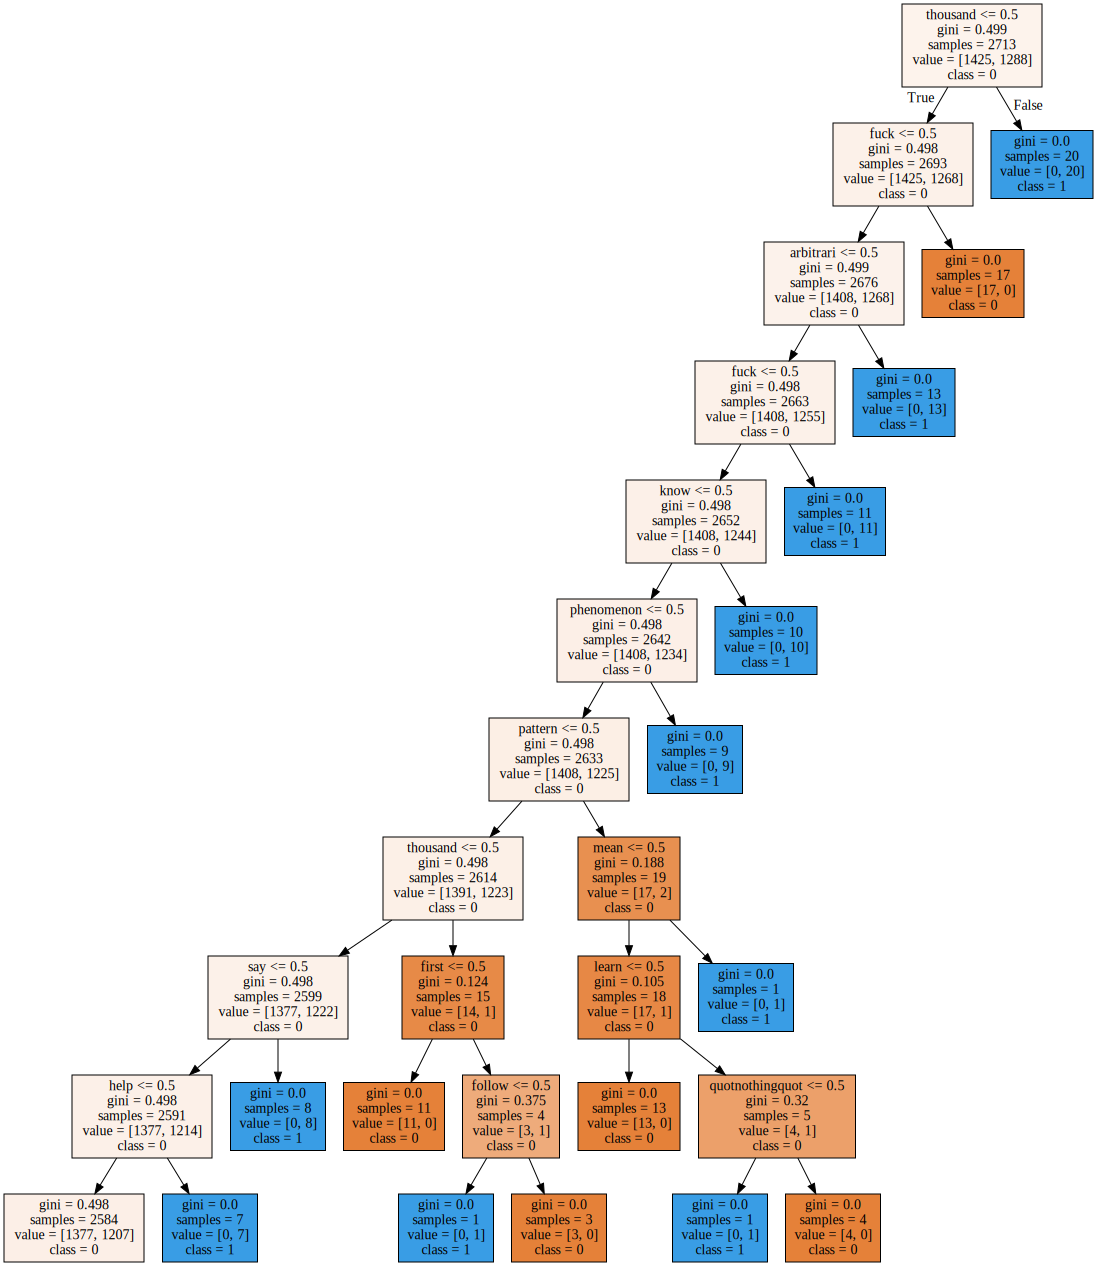

In [47]:
import graphviz

graphviz.Source(export_graphviz(dtr,
                                feature_names=wikiWords.columns,
                                filled=True,class_names=["0","1"]))

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

#####Evaluating

on training set

In [49]:
train_prediction = dtr.predict(X_train)

In [50]:
print('The mean absolute error',metrics.mean_absolute_error(y_train, train_prediction))
print('The accuracy:',metrics.accuracy_score(y_train, train_prediction))

The mean absolute error 0.4448949502395872
The accuracy: 0.5551050497604129


In [51]:
fpr, tpr, _ = roc_curve(y_train, train_prediction)

fig = px.line(x=fpr, y=tpr, title='ROC curve training set')
fig.show()

print('The AUC value on the training set is', roc_auc_score(y_train, train_prediction) )

The AUC value on the training set is 0.531444099378882


On testing set

In [52]:
test_prediction = dtr.predict(X_test)

In [53]:
print('The Mean absolute error',metrics.mean_absolute_error(y_test, test_prediction))
print("The accuracy:",metrics.accuracy_score(y_test, test_prediction))

The Mean absolute error 0.4290627687016337
The accuracy: 0.5709372312983663


In [54]:
fpr, tpr, _ = roc_curve(y_test, test_prediction)

fig = px.line(x=fpr, y=tpr, title='ROC curve training set')
fig.show()

print('The AUC value on the testing set is', roc_auc_score(y_test, test_prediction) )

The AUC value on the testing set is 0.5270532741398446


**Q8:** Given the performance of the CART model relative to the baseline, what is the best explanation of these results?

**A8:** Although it beats the baseline, bag of words is not very predictive for this problem. 

Explanation :

There is no reason to think there was anything wrong with the split. CART did not overfit, which you can check by computing the accuracy of the model on the training set. Over-sparsification is plausible but unlikely, since we selected a very high sparsity parameter. The only conclusion left is simply that bag of words didn't work very well in this case.

#Problem 2: Problem-specific Knowledge

**Q1** Based on this new column, how many revisions added a link?

**A1:** 217


In [55]:
wikiWords2 = wikiWords

Loop method

In [56]:
# c = data.apply(lambda x: x.str.contains('#http#').astype(object), axis=1).sum(axis=1)
# print(c)
s=[]
for i in data.Added:
  if 'http' in i:
    s.append(i)
len(s)

217

using str count 

In [57]:
import re 
search="http"
wikiWords2["http"]= data["Added"].str.count(search, re.I) 
# wikiWords2["http"] = np.where("http" in wikiWords2, 1, 0)
wikiWords2.value_counts("http")
#Command did actually add a column named "http" but it's no 1/0 , it counts how many http in added 

#summing the nonzero values === 217

http
0     3659
1      196
2       16
4        2
13       1
8        1
3        1
dtype: int64

In [58]:
#convert the nonzero to 1
wikiWords2.loc[wikiWords2.http != 0, 'http'] = 1
wikiWords2.value_counts("http")

http
0    3659
1     217
dtype: int64

**Q2:**
**A2:**